In [223]:
import itertools
import pandas as pd
import numpy as np
import networkx as nx
from networkx.algorithms.community import k_clique_communities

import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
%matplotlib inline

In [206]:
hosp = pd.read_csv('../Data(net)/hosp_sample.csv')
doc = pd.read_csv('../Data(net)/doc_sample.csv')
doc_net = pd.read_csv('../Data(net)/doc_network.csv')

In [207]:
def common_doc_names(Graph, node1_id, node2_id):
    name_list = []
    id_list = Graph.edge[node1_id][node2_id]['common_doc_ids']
    for ids in id_list:
        name_list.append(doc.iloc[ids,1])
    return name_list

In [208]:
# Graph G2 with nodes as hospitals and edges as doctors
G2 = nx.Graph()
G2.name = 'G2 (Node:Hospital, Edge:Doctors)'

In [209]:
#Creating Nodes

nodes_attr = []
for row in range(len(hosp)):
    attr = list(zip(hosp.columns[1:5], hosp.iloc[row,1:5]))
    attr = dict(attr)
    nodes_attr.append(attr)

nodes = list(zip(hosp['HOSP_ID'], nodes_attr))
G2.add_nodes_from(nodes)


In [210]:
#Creating Edges
for i,group in doc_net.groupby('DOC_ID')['HOSP_ID']:
    for u,v in itertools.combinations(group,2):
        set_u = set(doc_net[doc_net['HOSP_ID'] == u].DOC_ID)
        set_v = set(doc_net[doc_net['HOSP_ID'] == v].DOC_ID)
        common_doc_ids = set_u.intersection(set_v)
        G2.add_edge(u, v, {'common_doc_ids':list(common_doc_ids), 'weight':len(common_doc_ids)})


In [211]:
# sorted(G2.edges(data=True), key=lambda x:x[2]['weight'], reverse=True)[:5]

In [212]:
nx.write_weighted_edgelist(G2, 'G2.edges')

## Analysis

/home/robsr/miniconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/home/robsr/miniconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/home/robsr/miniconda3/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/home/robsr/miniconda3/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold i

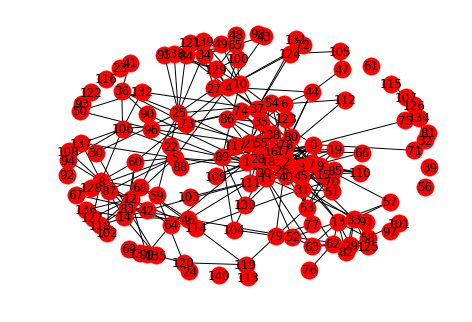

In [213]:
nx.draw(G2, with_labels=True)

In [214]:
# Graph Summary
print(nx.info(G2))

Name: G2 (Node:Hospital, Edge:Doctors)
Type: Graph
Number of nodes: 141
Number of edges: 379
Average degree:   5.3759


#### 1. Degree Centrality- 
The degree of a node is the number of other nodes to which it is connected.
$$ {C_D (u)} = \frac{deg(u)}{{n-1}} $$

In [215]:
# top 5 hospitals sorted according to their degrees
sorted(G2.degree().items(), key=lambda x:x[1], reverse=True)[:5]   # ex. (17,15) 17 is hosp_id and 35 is its degree

[(17, 35), (2, 23), (1, 18), (3, 18), (11, 18)]

In [216]:
degree_centrality = nx.degree_centrality(G2)
print(sorted(degree_centrality.items(), key=lambda x:x[1], reverse=True)[:5])
G2.node[17]

[(17, 0.25), (2, 0.16428571428571428), (1, 0.12857142857142856), (3, 0.12857142857142856), (11, 0.12857142857142856)]


{'HOSPITAL NAME': 'Fortis Hospital',
 'LOCATION': 'Mulund West, Mumbai',
 'NO. OF BEDS': 261,
 'NO. OF DOCTORS': 117}

Fortis Hospital Mumbai is the most connected hospital of all , it is connected to $25\%$ of other hospitals.

#### 2. Closeness Centrality
Closeness Centrality measures how many "hops" it would take to reach every other node in a network (taking the shortest path). It can be informally thought as 'average distance' to all other nodes.

$$ C_C (u) = \frac{n - 1}{\sum_{v=1}^{n-1} d(v, u)} $$

In [217]:
closeness_centrality = nx.closeness_centrality(G2)
sorted(closeness_centrality.items(), key=lambda x:x[1], reverse=True)[:5]    #top5 

[(17, 0.4062248995983936),
 (2, 0.38314393939393937),
 (1, 0.36916058394160584),
 (3, 0.3651624548736462),
 (0, 0.35)]

Averge distance of hospa from every other hospital is simply $\frac{1}{C_C (a)}$

In [218]:
1/closeness_centrality[17]

2.4616905585763718

#### 3. Betweenness Centrality
Betweenness centrality quantifies the number of times a node acts as a bridge (or "broker") along the shortest path between two other nodes.

In this conception, vertices that have a high probability to occur on a randomly chosen shortest path between two randomly chosen vertices have a high betweenness.

$$ C_B(v) =\sum_{s,t \in V} \frac{\sigma(s, t|v)}{\sigma(s, t)} $$

where ${\sigma(s, t)}$ is total number of shortest paths from node ${s}$ to node ${t}$ and ${\sigma(s, t|v)}$ is the number of those paths that pass through ${v}$.

In [219]:
betweeness_centrality = nx.betweenness_centrality(G2)
sorted(betweeness_centrality.items(), key=lambda x:x[1], reverse=True)[:5]    #top5 

[(17, 0.15776707748374744),
 (2, 0.1066610436817018),
 (4, 0.08501768870258668),
 (25, 0.07427354521904563),
 (11, 0.058137960038108415)]

#### 4. Eigenvector Centrality
A node is high in eigenvector centrality if it is connected to many other nodes who are themselves well connected.

In [220]:
eigenvector_centrality = nx.eigenvector_centrality_numpy(G2)
max_value = max(eigenvector_centrality.items(), key=lambda x: x[1])
print(max_value)
G2.node[11]

(11, 0.5435779396925297)


{'HOSPITAL NAME': 'Max Superspeciality Hospital',
 'LOCATION': 'Shalimar Bagh, Delhi',
 'NO. OF BEDS': 300,
 'NO. OF DOCTORS': 135}

In [221]:
ec_scaled = {}
for k in eigenvector_centrality.keys():
    ec_scaled[k] = eigenvector_centrality[k] / max_value[1]

# Scaled by the most central hospital Max Superspeciality Hospital
sorted(ec_scaled.items(), key=lambda x:x[1], reverse=True)[0:5]

[(11, 1.0),
 (20, 0.9824094753506455),
 (18, 0.5201068441382661),
 (1, 0.5157015885414343),
 (17, 0.35774782613401246)]

### Community Detection